In [1]:
import numpy as np
import scipy.sparse as sps
np.set_printoptions(precision=2)

import qiskit
from qiskit.visualization import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
sns.set(rc={'figure.figsize':(15, 6)})

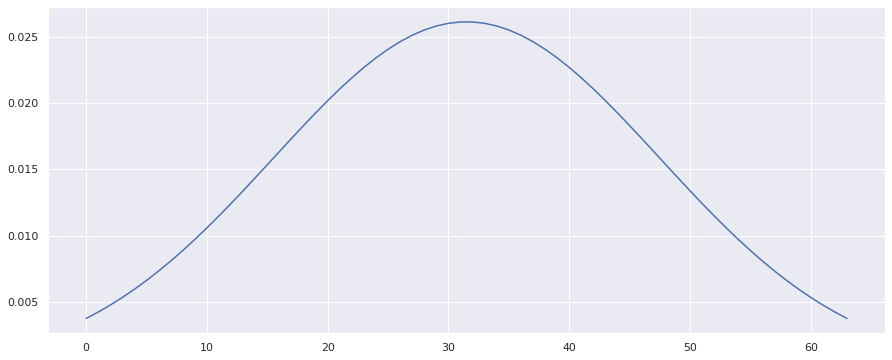

In [2]:
def gaussian(n_qubits, mu, sigma):
    x = np.arange(2 ** n_qubits)
    probs = 1. / np.sqrt(2 * np.pi * sigma ** 2) 
    probs *= np.exp(-(x - mu) ** 2 / (2. * sigma ** 2))
    return probs / probs.sum()

def generate_pair(n_qubits):
    pairs = [(i, i + 1) for i in range(n_qubits - 1)]
    pairs.append((n_qubits - 1, 0))
    return pairs

n_qubits = 6
n_layers = 6

data = gaussian(n_qubits, mu = 2 ** 5 - 0.5, sigma = 2 ** 4)

plt.plot(data)
plt.show()

## Quantum Born Machine

In [3]:
class MMDLoss:   

    def __init__(self, basis, sigmas, kernel_func):
        self.sigmas = sigmas
        self.basis = basis
        
        self.kernel = kernel_func(basis, basis, sigmas)

    def __call__(self, p_x, p_y):
        return (p_x - p_y) @ self.kernel @ (p_x - p_y)

    
def get_kernel(x, y, sigmas):
    kernel = 0.
    for sigma in sigmas:
        gamma = 1. / (2. * sigma)
        kernel += np.exp(-gamma * (x[:, None] - y[None, :]) ** 2)
    return kernel

In [4]:
# mmd loss
mmd = MMDLoss(np.arange(2 ** n_qubits), [0.25,4], get_kernel)

# when exact match, MMD loss should be 0, e.g. two gaussians
print('Exact Match {}'.format(mmd(data, data)))

# when not match, loss is not zero
probs = np.random.random(len(data))
print('Not Match {}'.format(mmd(probs / probs.sum(), data)))

Exact Match 0.0
Not Match 0.031296342829698676


In [5]:
class BornMachine:
    def __init__(self, backend, iterations, n_qubits, n_layers, 
                 pair_generator=generate_pair, loss_func=mmd):
        self.backend = backend
        self.iterations = iterations
        self.loss_func = loss_func
        
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.pair_generator = pair_generator
        
        self.circuit = qiskit.QuantumCircuit(self.n_qubits)
        
        self.params = {}
        for layer in range(n_layers):
            self._create_layer(layer)
        
        self.circuit.measure_all()
            
    def _create_layer(self, layer):
        # Insert RZ, RX, RZ rotation on each qubit
        for qubit in range(self.n_qubits):
            key = "{}:{}:{}".format(layer, qubit, 0)
            self.params[key] = qiskit.circuit.Parameter(key)
            self.circuit.rz(self.params[key], qubit)
            
            key = "{}:{}:{}".format(layer, qubit, 1)
            self.params[key] = qiskit.circuit.Parameter(key)
            self.circuit.rx(self.params[key], qubit)
            
            key = "{}:{}:{}".format(layer, qubit, 2)
            self.params[key] = qiskit.circuit.Parameter(key)
            self.circuit.rz(self.params[key], qubit)
        
        # Entangle qubits
        if layer != self.n_layers - 1:
            for qubit_1, qubit_2 in self.pair_generator(self.n_qubits):
                self.circuit.cx(qubit_1, qubit_2)
            self.circuit.barrier()
        
    def _bind_parameters(self, values):
        # TODO: set leading and trailing Rz to disabled
        parameter_binds = {}
        for key, value in zip(list(self.params.keys()), values):
            parameter_binds[self.params[key]] = value
        return parameter_binds
    
    def set_target(self, target):
        self.target = target
    
    def get_probablities(self, params):
        job = qiskit.execute(self.circuit, self.backend, shots=self.iterations,
                             parameter_binds=[self._bind_parameters(params)])

        result = job.result().get_counts(self.circuit)

        counts = np.array(list(result.values()))
        states = [int(key, 2) for key in np.array(list(result.keys()))]

        probabilities = np.zeros(2 ** len(self.circuit.qubits)) 
        probabilities[states] = counts
        probabilities /= self.iterations

        return np.array(probabilities)
    
    def loss(self, params):
        predicted = self.get_probablities(params)
        return self.loss_func(predicted, self.target)
    
    def sample(self):
        pass
    
    def gradient(self, params, shift=1e-2):
        probabilities = self.get_probablities(params)

        shift_right = params + np.eye(len(params)) * shift / 2
        shift_left = params - np.eye(len(params)) * shift / 2
        
        gradients = []
        for i in range(len(params)):
            loss_right = self.loss(shift_right[i])
            loss_left = self.loss(shift_left[i])
            gradients.append((loss_right - loss_left) / shift)
            
        return np.array(gradients)

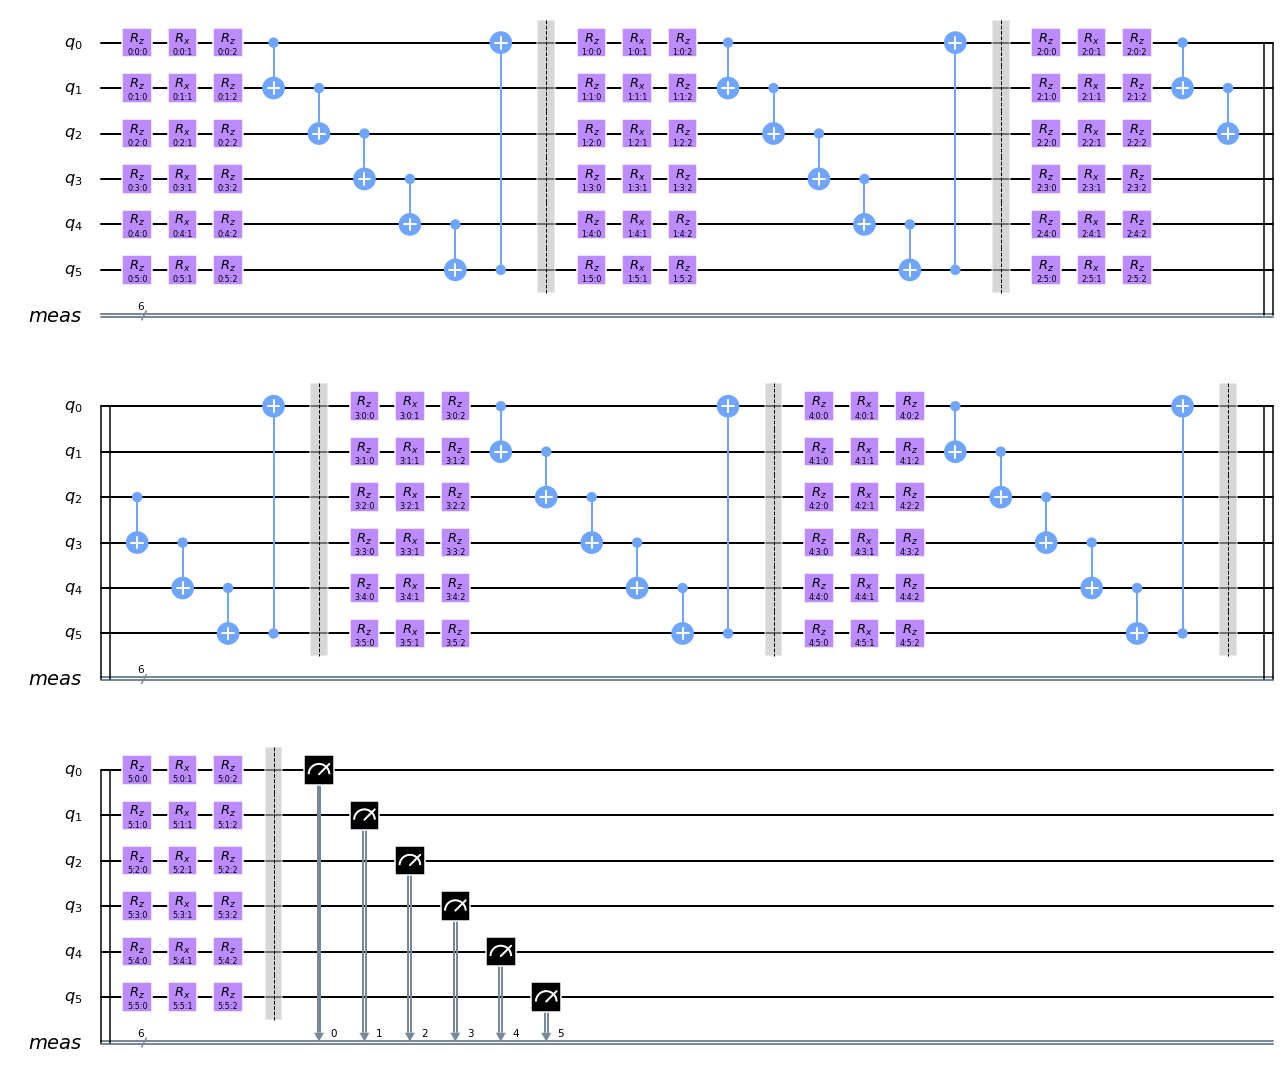

In [6]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

model = BornMachine(simulator, 1000, n_qubits, n_layers)
model.circuit.draw()

Initial loss 0.09


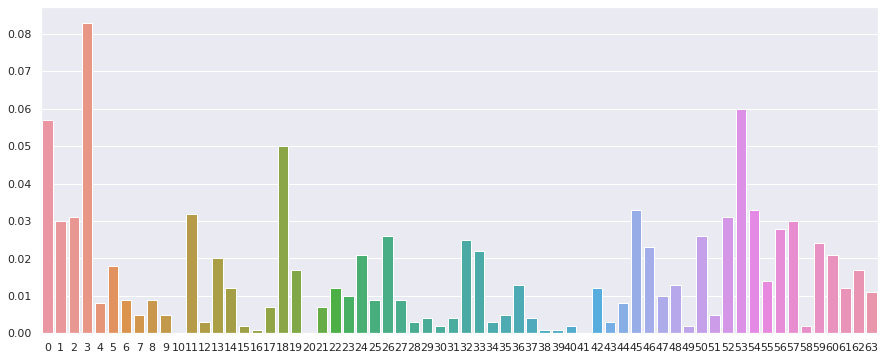

In [7]:
init_params = np.array([])
for key in model.params.keys():
    init_params = np.append(init_params, np.random.random())
    
distribution = model.get_probablities(init_params)
model.set_target(data)
sns.barplot(x = np.arange(len(distribution)), y = distribution)
print("Initial loss {0:0.2f}".format(model.loss(init_params)))

In [20]:
from scipy.optimize import minimize

def callback(x, *args, **kwargs):
    print("Loss {}".format(model.loss(x)))

result = minimize(model.loss, x0=init_params, method='L-BFGS-B',
                  jac=model.gradient, tol=1e-12,
                  options={
                      'maxiter': 20
                      }, 
                  callback=callback)

Loss 0.09376483757670494
Loss 0.09923808387427444


In [21]:
result.message

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

Initial loss 0.0955


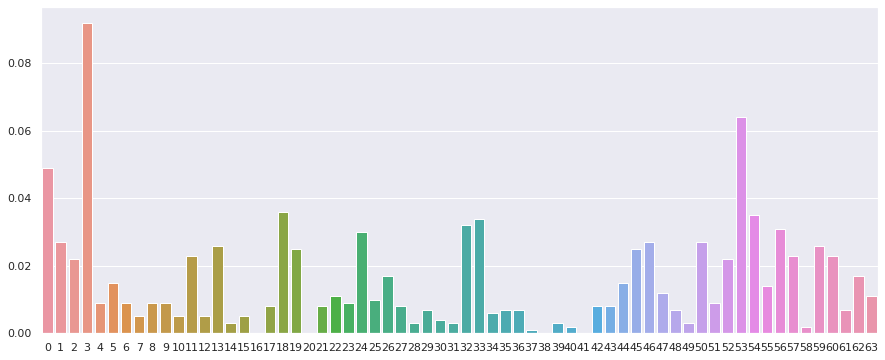

In [19]:
distribution = model.get_probablities(result.x)

sns.barplot(x = np.arange(len(distribution)), y = distribution)
print("Initial loss {0:0.4f}".format(model.loss(result.x)))

#### Literature
"Differentiable learning of quantum circuit Born machines" Liu and Wang & example code that accompanied the paper